<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

# Reinforcement Learning for Finance

**Chapter 08 &mdash; Asset Allocation**

&copy; Dr. Yves J. Hilpisch

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>

## Capital Market Line

In [1]:
import math
import random
import numpy as np
import pandas as pd
from scipy import stats
from pylab import plt, mpl

In [2]:
plt.style.use('seaborn-v0_8')
mpl.rcParams['figure.dpi'] = 300
mpl.rcParams['savefig.dpi'] = 300
mpl.rcParams['font.family'] = 'serif'
np.set_printoptions(suppress=True)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

In [3]:
r = 0.025
beta = 0.2
sigma = 0.375
mu = r + beta * sigma
mu

0.1

In [4]:
vol = np.linspace(0, 0.5)
ret = r + beta * vol

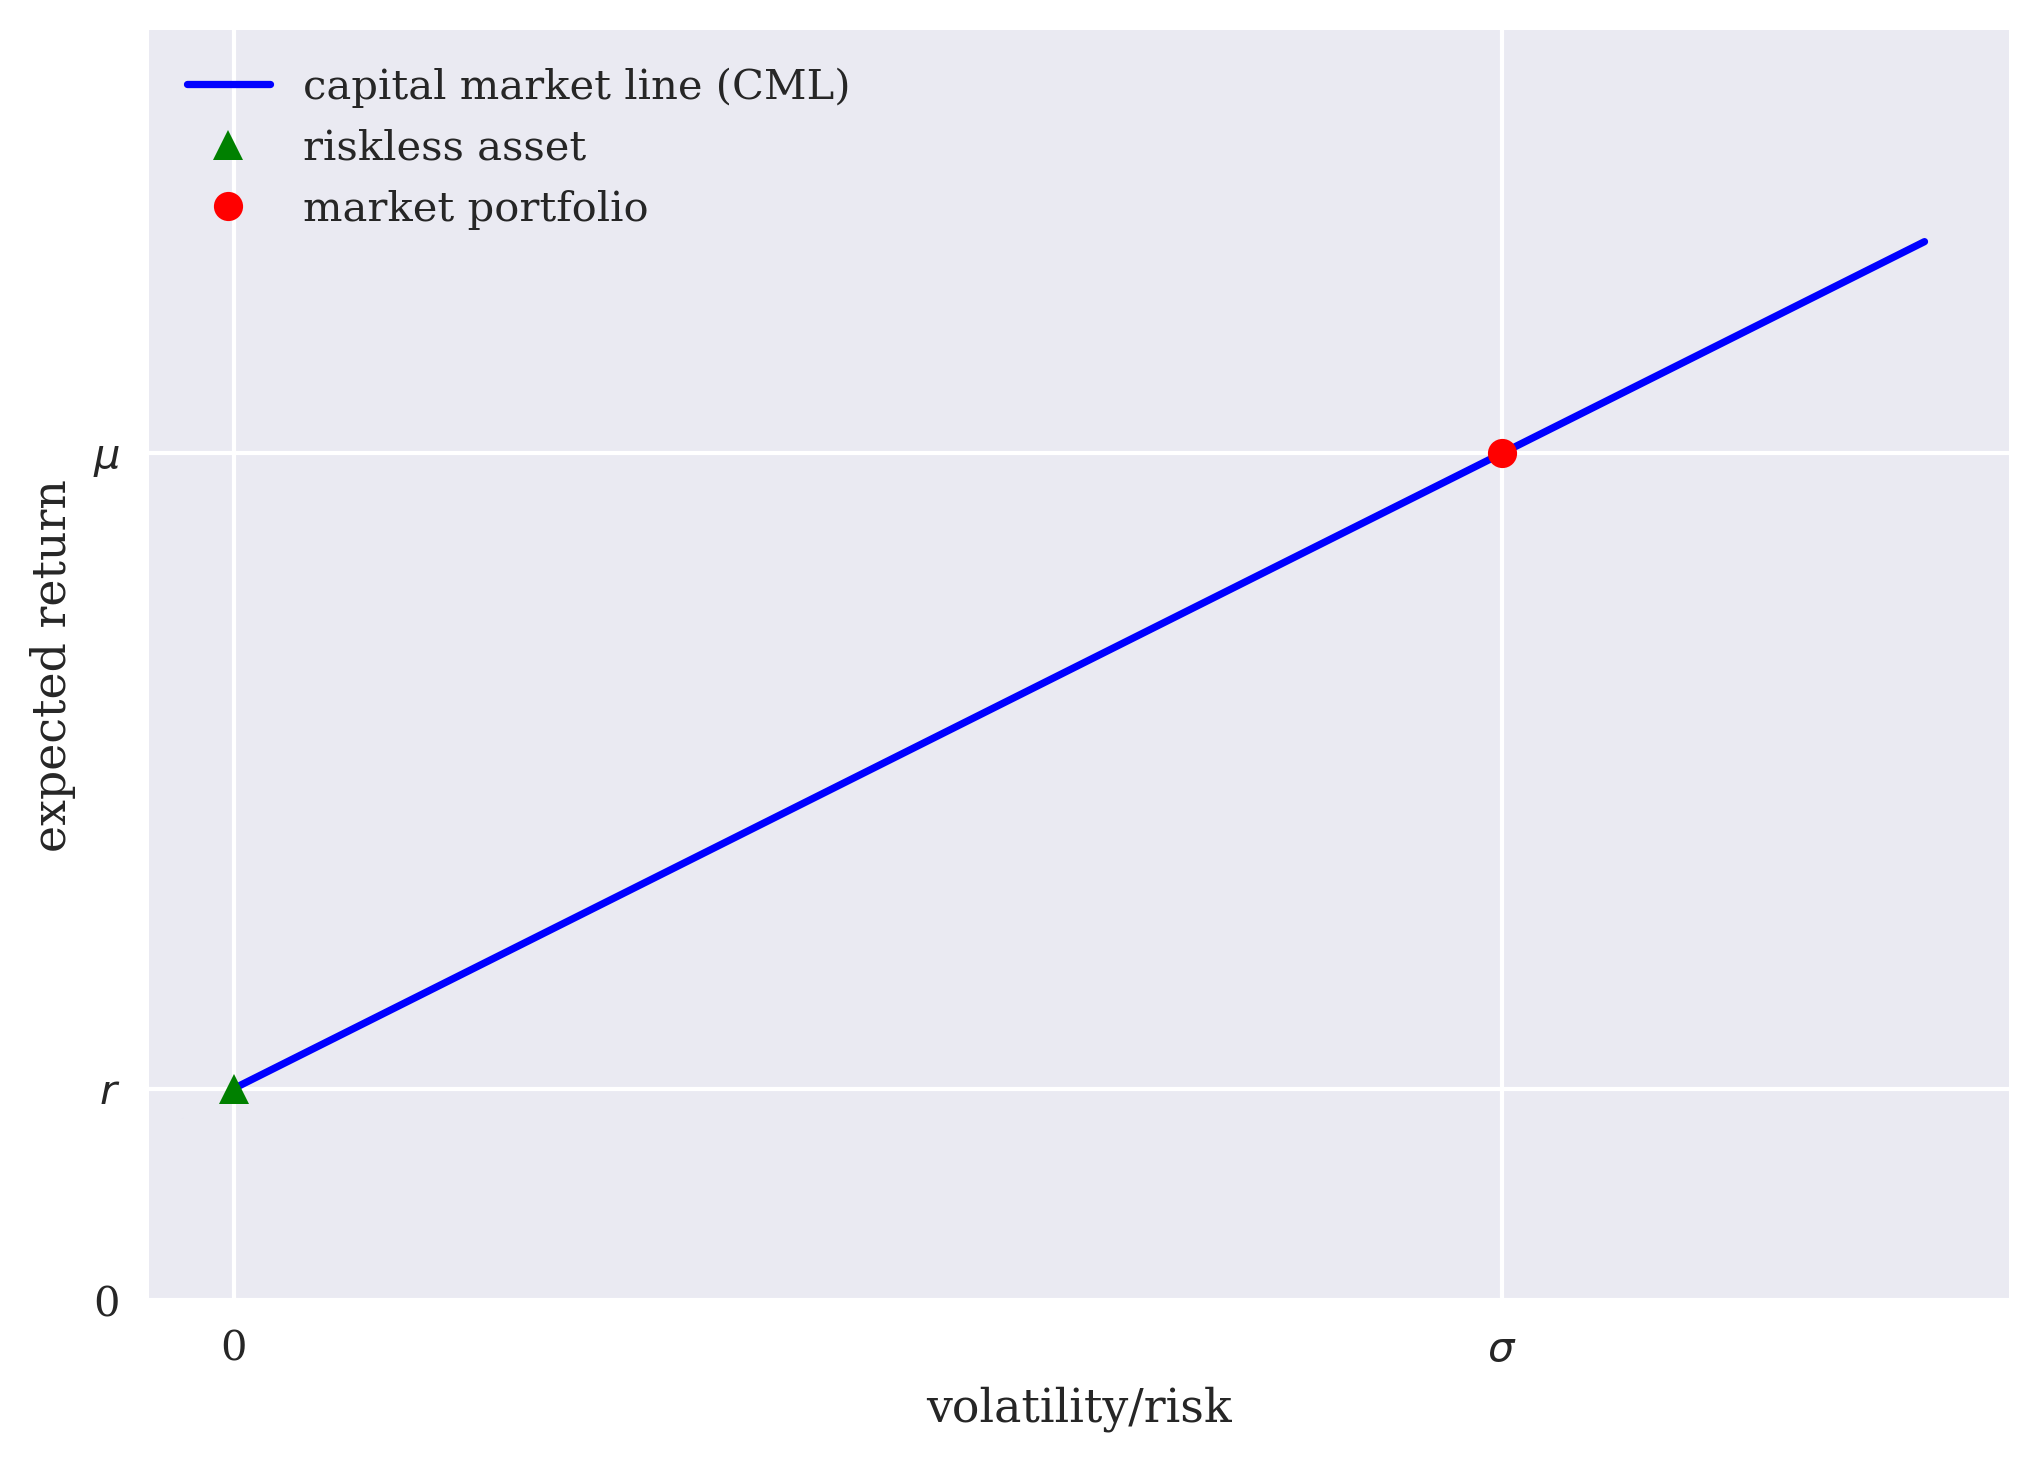

In [5]:
fig, ax = plt.subplots()
plt.plot(vol, ret, 'b', label='capital market line (CML)')
plt.plot(0, r, 'g^', label='riskless asset')
plt.plot(sigma, mu, 'ro', label='market portfolio')
plt.xlabel('volatility/risk')
plt.ylabel('expected return')
ax.set_xticks((0, sigma))
ax.set_xticklabels((0, '$\sigma$',))
ax.set_yticks((0, r, mu))
ax.set_yticklabels((0, '$r$', '$\mu$'))
plt.ylim(0, 0.15)
plt.legend();

## Investing Environment

In [6]:
class observation_space:
    def __init__(self, n):
        self.shape = (n,)

In [7]:
class action_space:
    def __init__(self, n):
        self.n = n
        
    def seed(self, seed):
        random.seed(seed)
        
    def sample(self):
        return random.random()

In [8]:
class Investing:
    def __init__(self, S0, T, r_, mu_, sigma_, steps, amount):
        self.initial_value = S0
        self.maturity = T
        self.short_rate_ = r_
        self.index_drift_ = mu_
        self.volatility_ = sigma_
        self.steps = steps
        self.initial_balance = amount
        self.portfolio_value = amount
        self.portfolio_value_new = amount
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(1)
        self._generate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0

In [9]:
class Investing(Investing):
    def _generate_data(self):
        s = [self.initial_value]
        self.short_rate = random.choice(self.short_rate_)
        self.index_drift = random.choice(self.index_drift_)
        self.volatility = random.choice(self.volatility_)
        self.dt = self.maturity / self.steps
        for t in range(1, self.steps + 1):
            st = s[t - 1] * math.exp(
                ((self.index_drift - self.volatility ** 2 / 2) * self.dt +
                  self.volatility * math.sqrt(self.dt) * random.gauss(0, 1))
            )
            s.append(st)
        self.data = pd.DataFrame(s, columns=['Xt'])
        self.data['Yt'] = self.initial_value * np.exp(
            self.short_rate * np.arange(len(self.data)) * self.dt)

In [10]:
class Investing(Investing):
    def _get_state(self):
        Xt = self.data['Xt'].iloc[self.bar]
        Yt = self.data['Yt'].iloc[self.bar]
        return np.array([Xt, Yt, self.xt, self.yt]), {}
        
    def seed(self, seed=None):
        if seed is not None:
            random.seed(seed)
            
    def reset(self):
        self.bar = 0
        self.xt = 0
        self.yt = 0
        self.treward = 0
        self.portfolio_value = self.initial_balance
        self.portfolio_value_new = self.initial_balance
        self.episode += 1
        self._generate_data()
        self.state, _ = self._get_state()
        return self.state, _

In [11]:
class Investing(Investing):
    def add_results(self, pl):
        df = pd.DataFrame({'e': self.episode, 'xt': self.xt,
                   'yt': self.yt, 'pv': self.portfolio_value,
                   'pv_new': self.portfolio_value_new, 'p&l[$]': pl, 
                   'p&l[%]': pl / self.portfolio_value_new,
                   'Xt': self.state[0],  'Yt': self.state[1],
                   'Xt_new': self.new_state[0],
                   'Yt_new': self.new_state[1],
                   'r': self.short_rate, 'mu': self.index_drift,
                   'sigma': self.volatility}, index=[0])
        self.portfolios = pd.concat((self.portfolios, df),
                                    ignore_index=True)
        
    def step(self, action):
        self.bar += 1
        self.new_state, _ = self._get_state()
        if self.bar == 1:
            self.xt = action
            self.yt = (1 - action)
            pl = 0.
            reward = 0.
            self.add_results(pl)
        else:
            self.portfolio_value_new = (
                self.xt * self.portfolio_value *
                self.new_state[0] / self.state[0] +
                self.yt * self.portfolio_value *
                self.new_state[1] / self.state[1])
            pl = self.portfolio_value_new - self.portfolio_value
            self.xt = action
            self.yt = (1 - action)
            self.add_results(pl)
            reward = pl
            self.portfolio_value = self.portfolio_value_new
        if self.bar == len(self.data) - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, reward, done, False, {}

In [12]:
S0 = 1.

In [13]:
investing = Investing(S0=S0, T=1.0, r_=[0.05], mu_=[0.3],
              sigma_=[0.35], steps=252, amount=1)

In [14]:
investing.seed(750)

In [15]:
investing._generate_data()

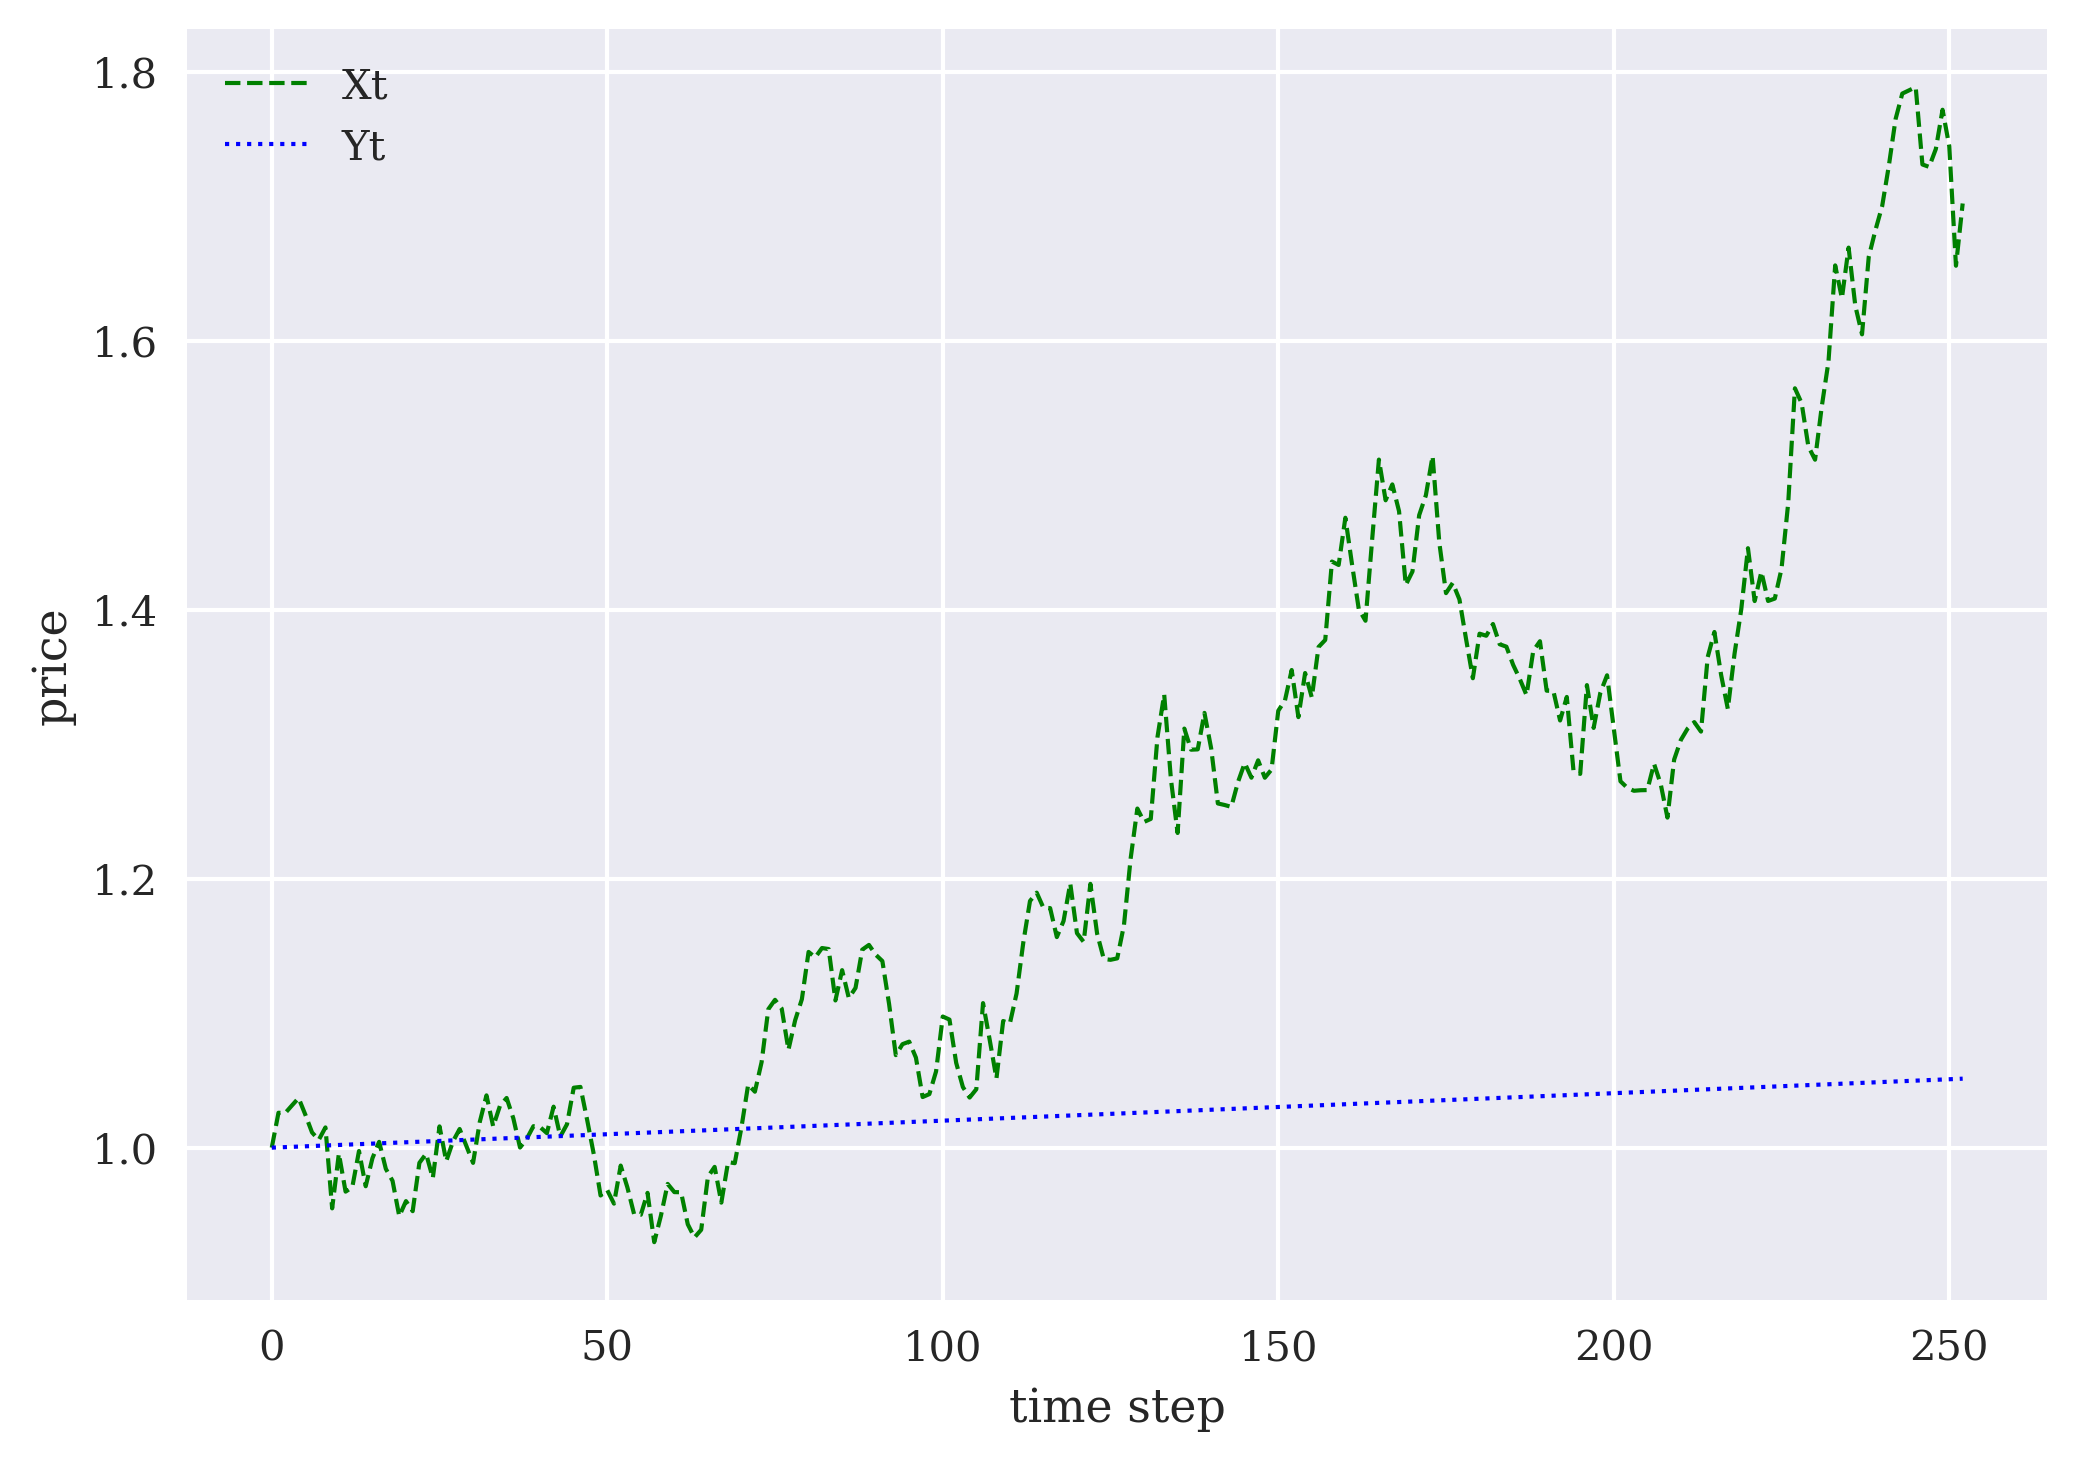

In [16]:
investing.data.plot(style=['g--', 'b:'], lw=1.0)
plt.xlabel('time step')
plt.ylabel('price');

## Investing Agent

In [17]:
investing.reset()

(array([1., 1., 0., 0.]), {})

In [18]:
for _ in range(investing.steps - 1):
    investing.step(investing.action_space.sample())

In [19]:
investing.portfolios.head().round(3)

,e,xt,yt,pv,pv_new,p&l[$],p&l[%],Xt,Yt,Xt_new,Yt_new,r,mu,sigma
0,1,0.587,0.413,1.000,1.000,0.000,0.000,1.000,1.000,0.979,1.000,0.050,0.300,0.350
1,1,0.001,0.999,1.000,1.009,0.009,0.008,0.979,1.000,0.994,1.000,0.050,0.300,0.350
2,1,0.838,0.162,1.009,1.009,0.000,0.000,0.994,1.000,0.973,1.001,0.050,0.300,0.350
3,1,0.981,0.019,1.009,0.998,-0.011,-0.011,0.973,1.001,0.961,1.001,0.050,0.300,0.350
4,1,0.167,0.833,0.998,0.978,-0.020,-0.020,0.961,1.001,0.941,1.001,0.050,0.300,0.350


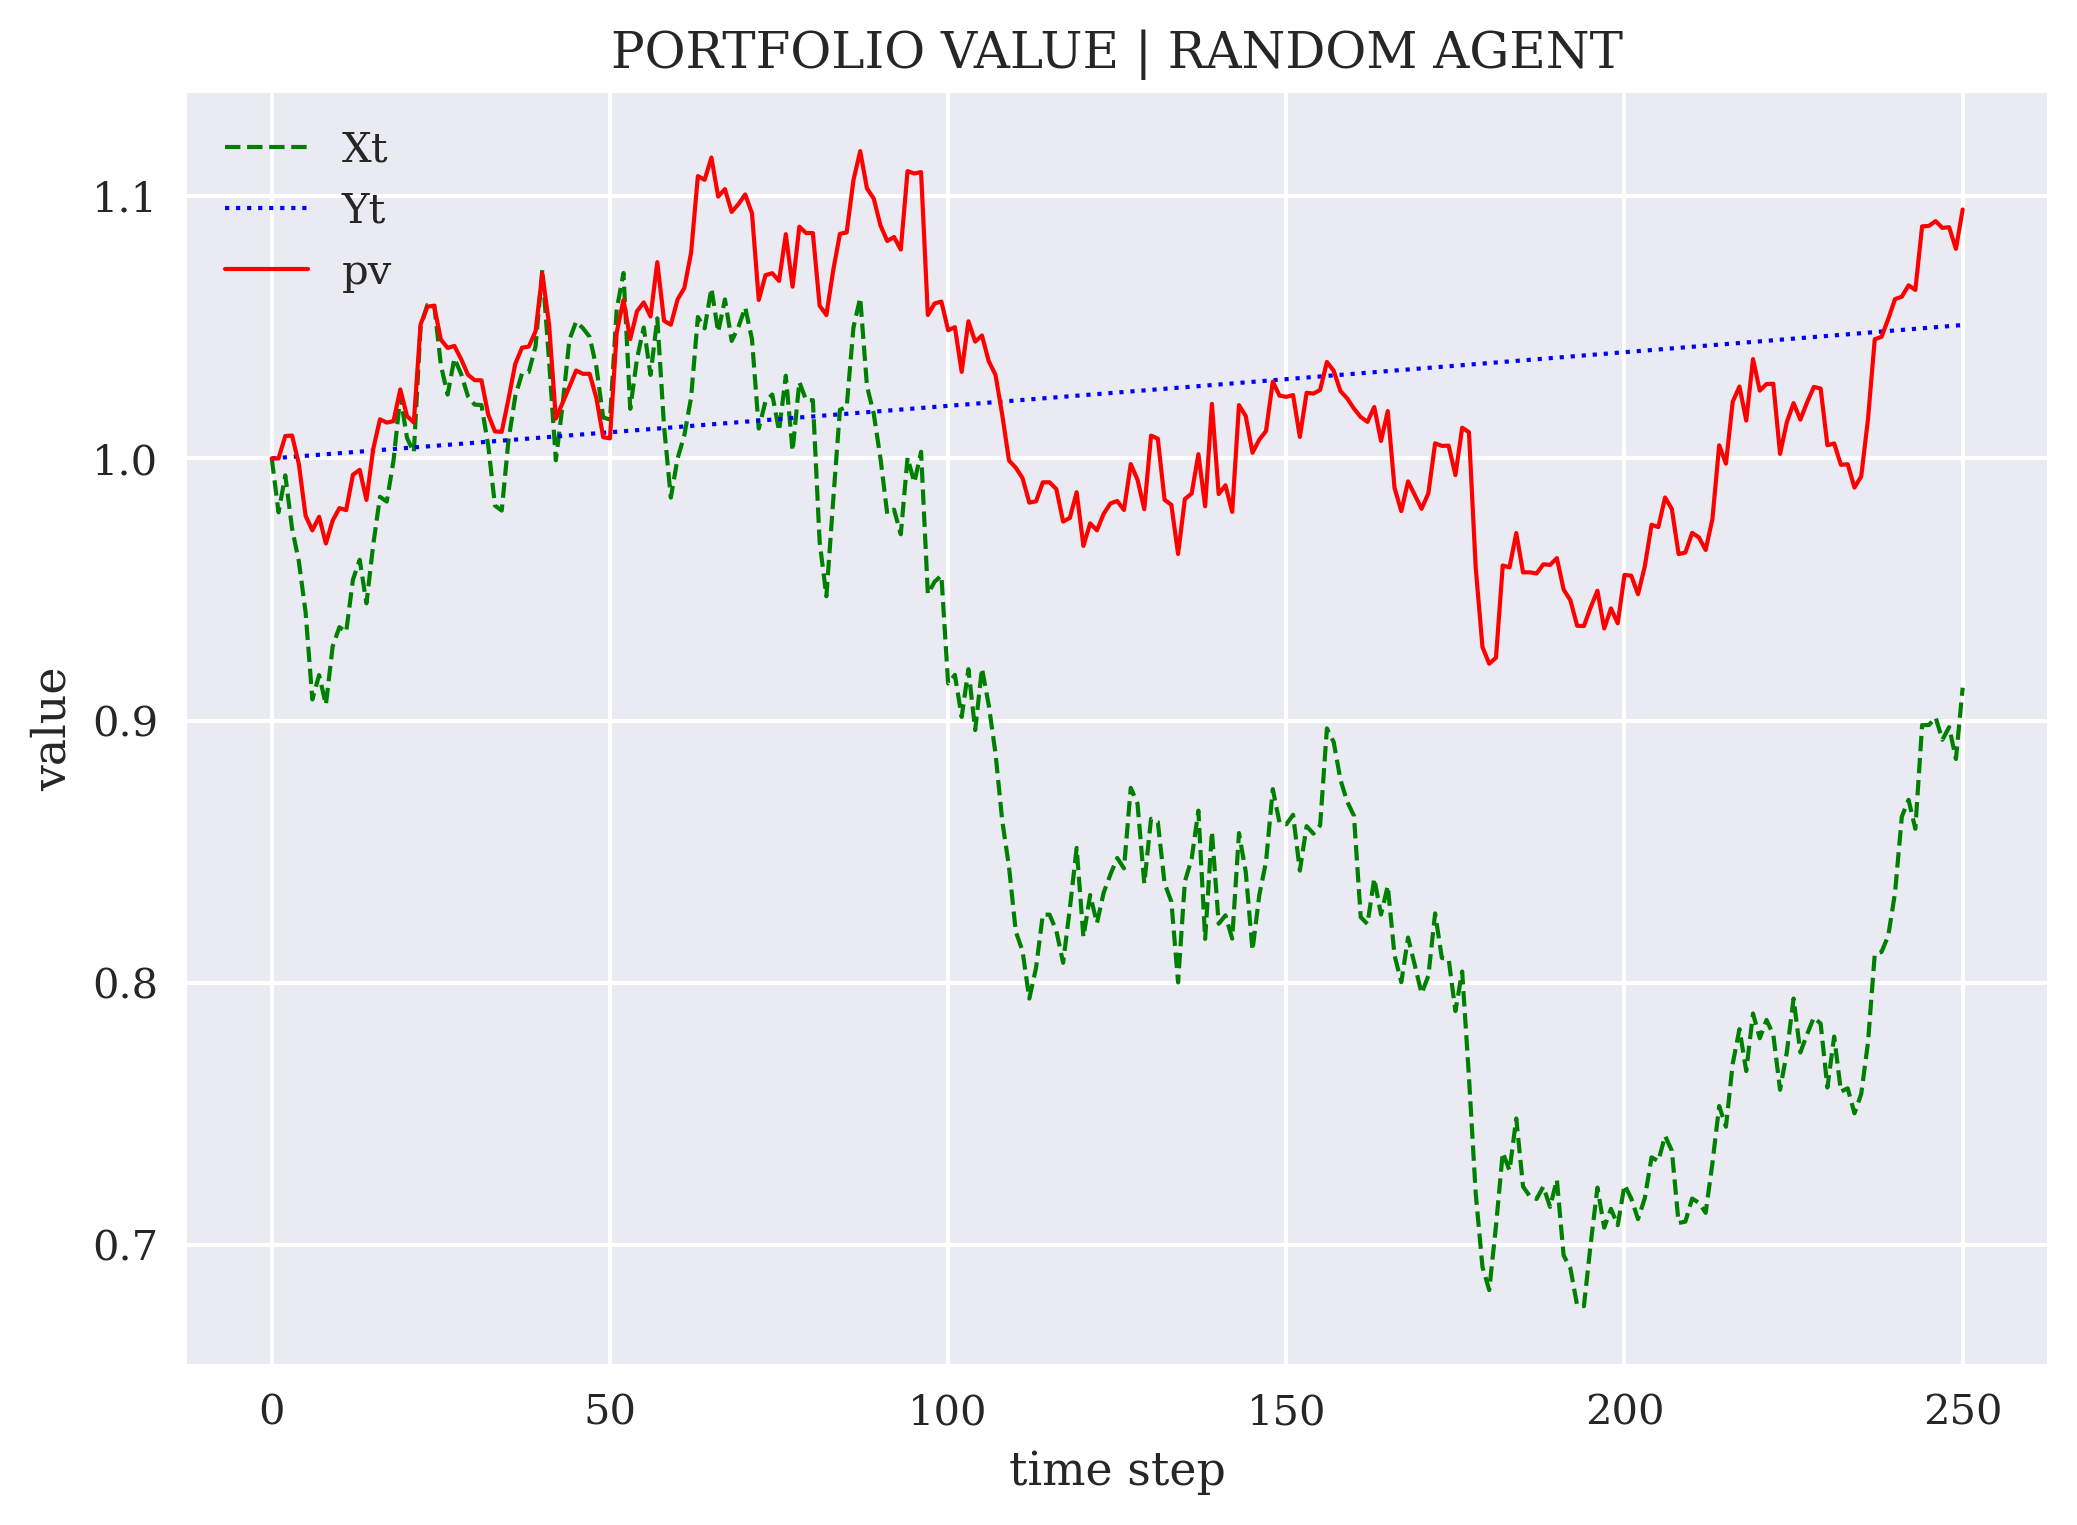

In [20]:
investing.portfolios[['Xt', 'Yt', 'pv']].plot(
    title='PORTFOLIO VALUE | RANDOM AGENT',
    style=['g--', 'b:', 'r-'], lw=1)
plt.xlabel('time step')
plt.ylabel('value');

In [21]:
from dqlagent_pytorch import *

In [22]:
opt = optim.Adam


In [23]:
class InvestingAgent(DQLAgent):
    pass


In [24]:
from scipy.optimize import minimize

In [25]:
class InvestingAgent(InvestingAgent):
    def opt_action(self, state):
        bnds = [(0, 1)]
        def f_obj(x):
            s = state.copy()
            s[0, self.xp] = x
            s[0, self.yp] = 1 - x
            s_tensor = torch.FloatTensor(s).to(device)
            with torch.no_grad():
                q_val = self.model(s_tensor)
            return q_val.cpu().numpy()[0, 0]
        try:
            res = minimize(lambda x: -f_obj(x), 0.5, bounds=bnds, method="Nelder-Mead")
            action = res["x"][0]
        except:
            action = self.env.action_space.sample()
        return action
    def act(self, state):
        if random.random() <= self.epsilon:
            return self.env.action_space.sample()
        return self.opt_action(state)

In [26]:
class InvestingAgent(InvestingAgent):
    def replay(self):
        if len(self.memory) < self.batch_size:
            return
        batch = random.sample(self.memory, self.batch_size)
        for state, action, next_state, reward, done in batch:
            target = torch.tensor([reward], dtype=torch.float32).to(device)
            if not done:
                ns = next_state.copy()
                opt_act = self.opt_action(ns)
                ns[0, self.xp] = opt_act
                ns[0, self.yp] = 1 - opt_act
                ns_tensor = torch.FloatTensor(ns).to(device)
                with torch.no_grad():
                    future_q = self.model(ns_tensor)[0, 0]
                target = target + self.gamma * future_q
            state_tensor = torch.FloatTensor(state).to(device)
            self.optimizer.zero_grad()
            current_q = self.model(state_tensor)[0, 0]
            loss = self.criterion(current_q, target)
            loss.backward()
            self.optimizer.step()
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

In [27]:
class InvestingAgent(InvestingAgent):
    def test(self, episodes, verbose=True):
        for e in range(1, episodes + 1):
            state, _ = self.env.reset()
            state = self._reshape(state)
            treward = 0
            for _ in range(1, len(self.env.data) + 1):
                action = self.opt_action(state)
                state, reward, done, trunc, _ = self.env.step(action)
                state = self._reshape(state)
                treward += reward
                if done:
                    templ = f"episode={e} | total reward={treward:4.2f}"
                    if verbose:
                        print(templ, end="\r")
                    break

In [28]:
def set_seeds(seed=500):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

In [29]:
set_seeds()

In [30]:
investing = Investing(S0=S0, T=1.0, r_=[0, 0.025, 0.05],
              mu_=[0.05, 0.1, 0.15],
              sigma_=[0.1, 0.2, 0.3], steps=252, amount=1) 

In [31]:
agent = InvestingAgent('2FS', feature=None, n_features=4,
                     env=investing, hu=128, lr=0.00025)

In [32]:
agent.xp = 2
agent.yp = 3

In [33]:
episodes = 50

In [34]:
%time agent.learn(episodes)

episode=   1 | treward=  0.034 | max=  0.034
episode=   2 | treward= -0.047 | max=  0.034
episode=   3 | treward=  0.098 | max=  0.098
episode=   4 | treward=  0.052 | max=  0.098
episode=   5 | treward=  0.157 | max=  0.157
episode=   6 | treward=  0.077 | max=  0.157
episode=   7 | treward=  0.028 | max=  0.157
episode=   8 | treward= -0.007 | max=  0.157
episode=   9 | treward=  0.117 | max=  0.157
episode=  10 | treward=  0.153 | max=  0.157
episode=  11 | treward=  0.105 | max=  0.157
episode=  12 | treward=  0.257 | max=  0.257
episode=  13 | treward= -0.151 | max=  0.257
episode=  14 | treward=  0.465 | max=  0.465
episode=  15 | treward= -0.008 | max=  0.465
episode=  16 | treward= -0.047 | max=  0.465
episode=  17 | treward= -0.008 | max=  0.465
episode=  18 | treward=  0.242 | max=  0.465
episode=  19 | treward=  0.051 | max=  0.465
episode=  20 | treward=  0.159 | max=  0.465
episode=  21 | treward=  0.263 | max=  0.465
episode=  22 | treward=  0.009 | max=  0.465
episode=  

In [35]:
agent.epsilon

0.09997053357470892

In [36]:
agent.env.portfolios = pd.DataFrame()

In [37]:
%time agent.test(10)

CPU times: user 4.69 s, sys: 221 ms, total: 4.91 s
Wall time: 3.68 s


In [38]:
n = max(agent.env.portfolios['e'])

In [39]:
res = agent.env.portfolios[agent.env.portfolios['e'] == n]
res.head()

,e,xt,yt,pv,pv_new,p&l[$],p&l[%],Xt,Yt,Xt_new,Yt_new,r,mu,sigma
2268,60,0.500,0.500,1.000,1.000,0.000,0.000,1.000,1.000,1.004,1.000,0.050,0.050,0.300
2269,60,0.500,0.500,1.000,0.996,-0.004,-0.004,1.004,1.000,0.996,1.000,0.050,0.050,0.300
2270,60,0.500,0.500,0.996,0.978,-0.018,-0.018,0.996,1.000,0.960,1.001,0.050,0.050,0.300
2271,60,0.500,0.500,0.978,0.984,0.006,0.006,0.960,1.001,0.972,1.001,0.050,0.050,0.300
2272,60,0.500,0.500,0.984,0.990,0.005,0.005,0.972,1.001,0.983,1.001,0.050,0.050,0.300


In [40]:
p = res.iloc[0][['r', 'mu', 'sigma']]

In [41]:
t = f"r={p['r']} | mu={p['mu']} | sigma={p['sigma']}"

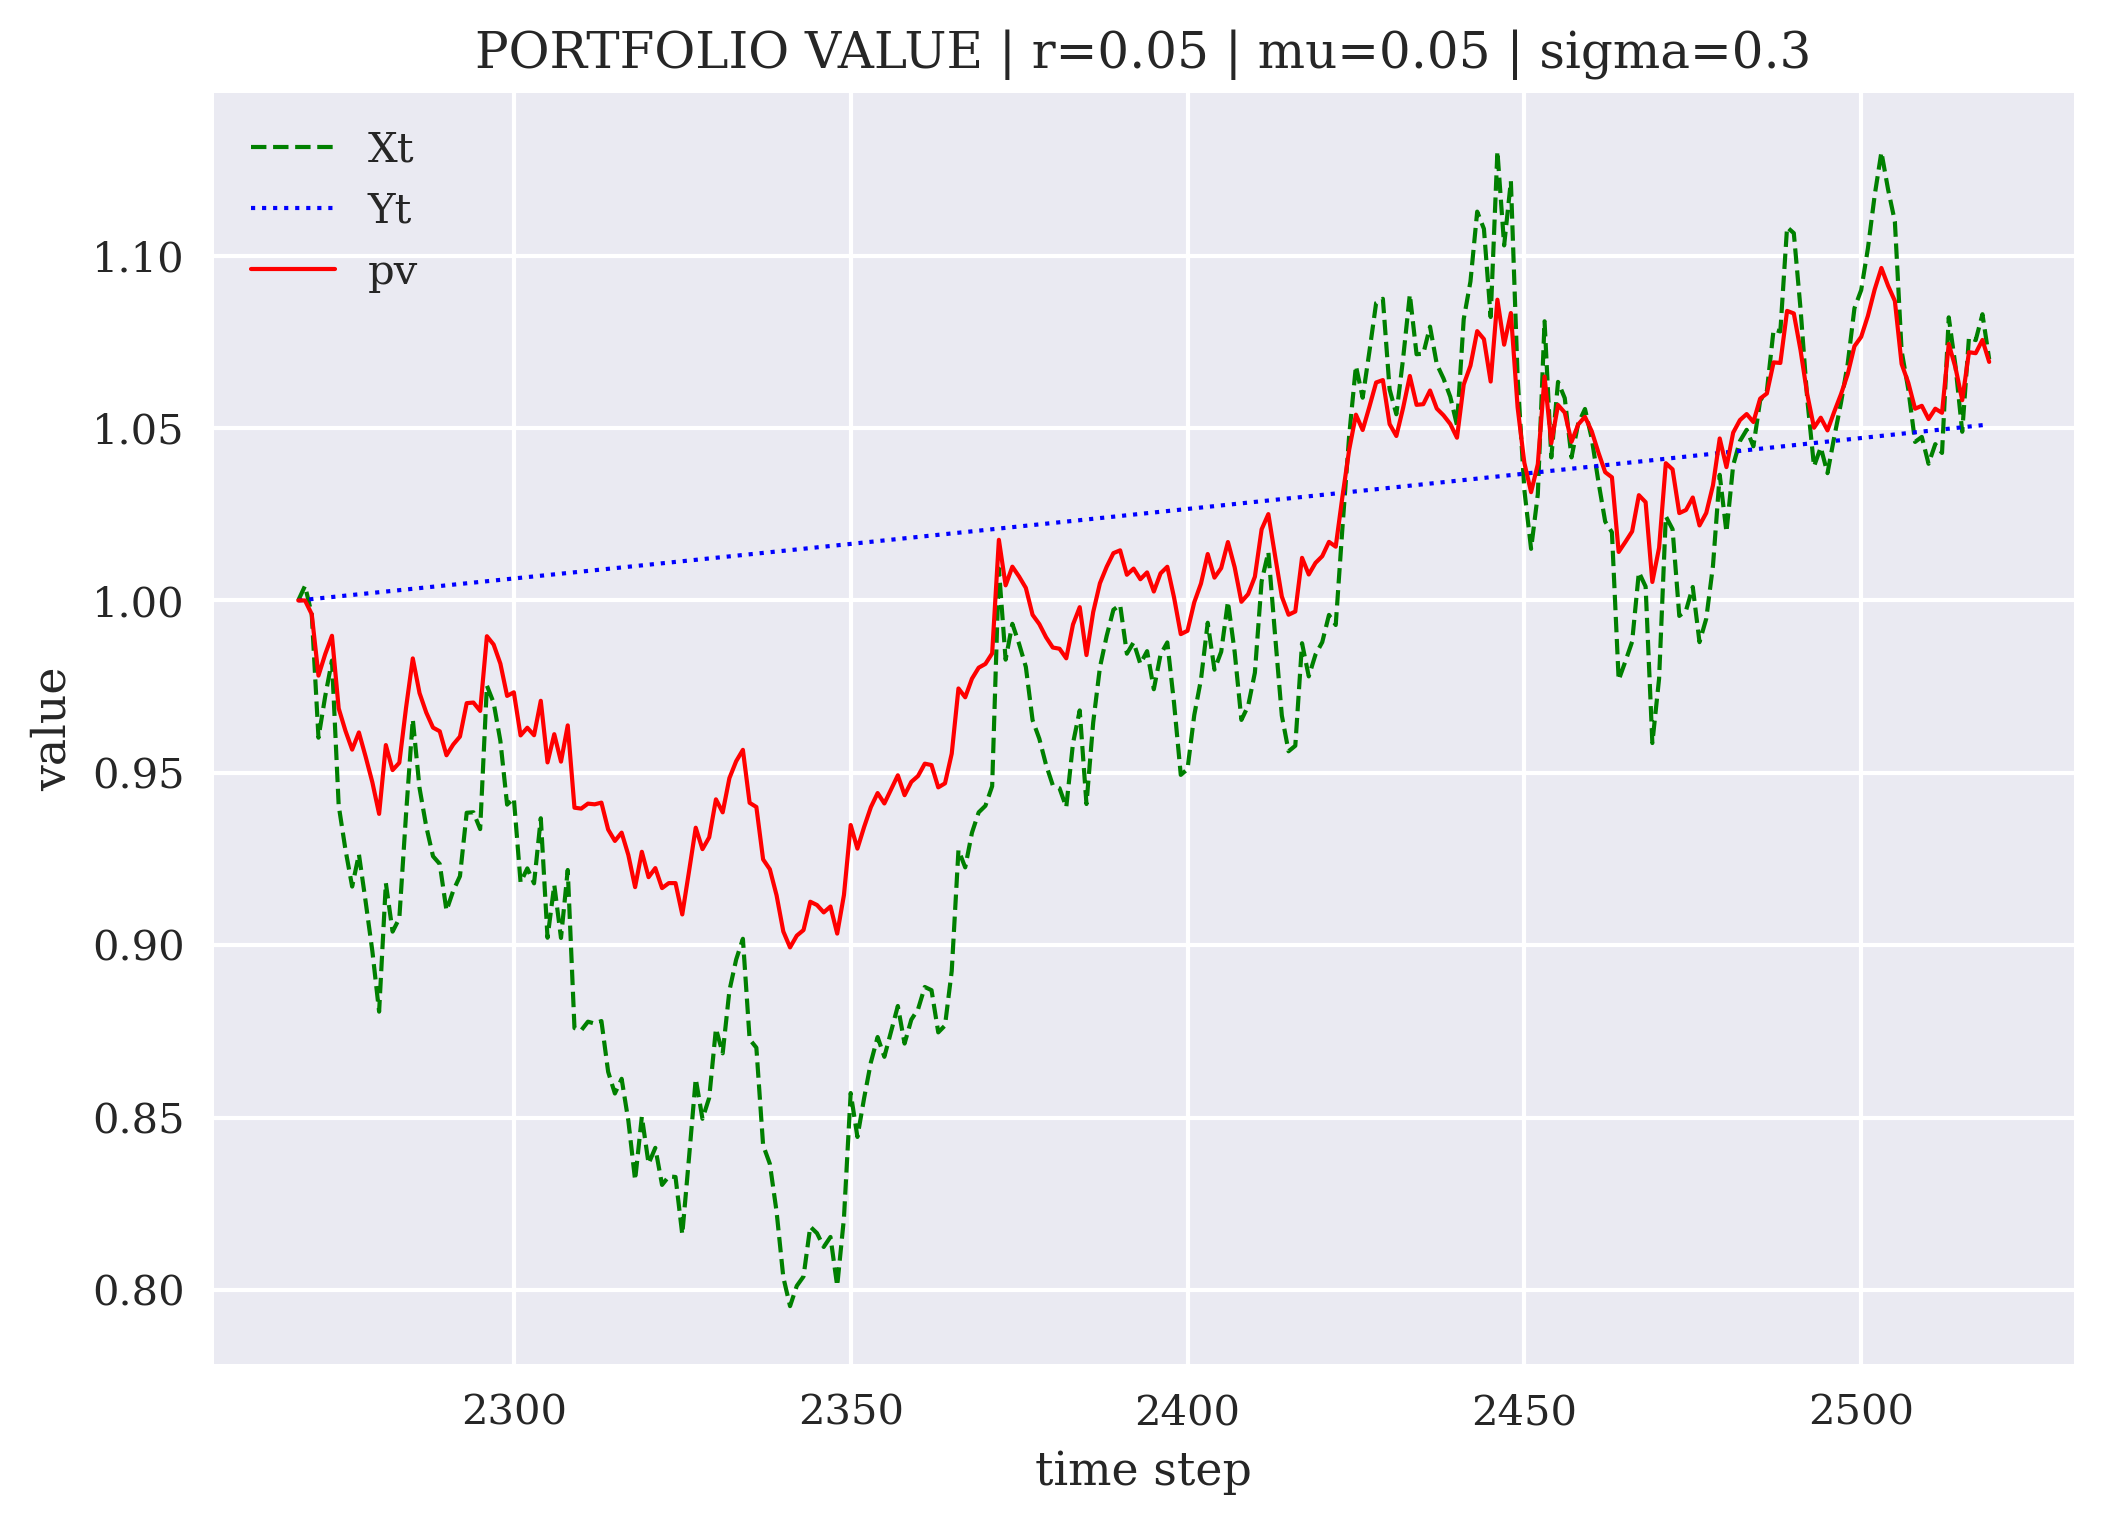

In [42]:
res[['Xt', 'Yt', 'pv']].plot(
    title='PORTFOLIO VALUE | ' + t,
    style=['g--', 'b:', 'r-'], lw=1)
plt.xlabel('time step')
plt.ylabel('value');

In [43]:
rets = res[['Xt', 'Yt', 'pv']].pct_change(
    ).mean() / agent.env.dt
rets

Xt   0.110
Yt   0.050
pv   0.078
dtype: float64

In [44]:
stds = res[['Xt', 'Yt', 'pv']].pct_change(
    ).std() / math.sqrt(agent.env.dt)
stds

Xt   0.290
Yt   0.000
pv   0.145
dtype: float64

In [45]:
rets[['Xt', 'pv']] / stds[['Xt', 'pv']]

Xt   0.378
pv   0.536
dtype: float64

In [46]:
res['xt'].mean()

0.5

In [47]:
res['xt'].std()

0.0

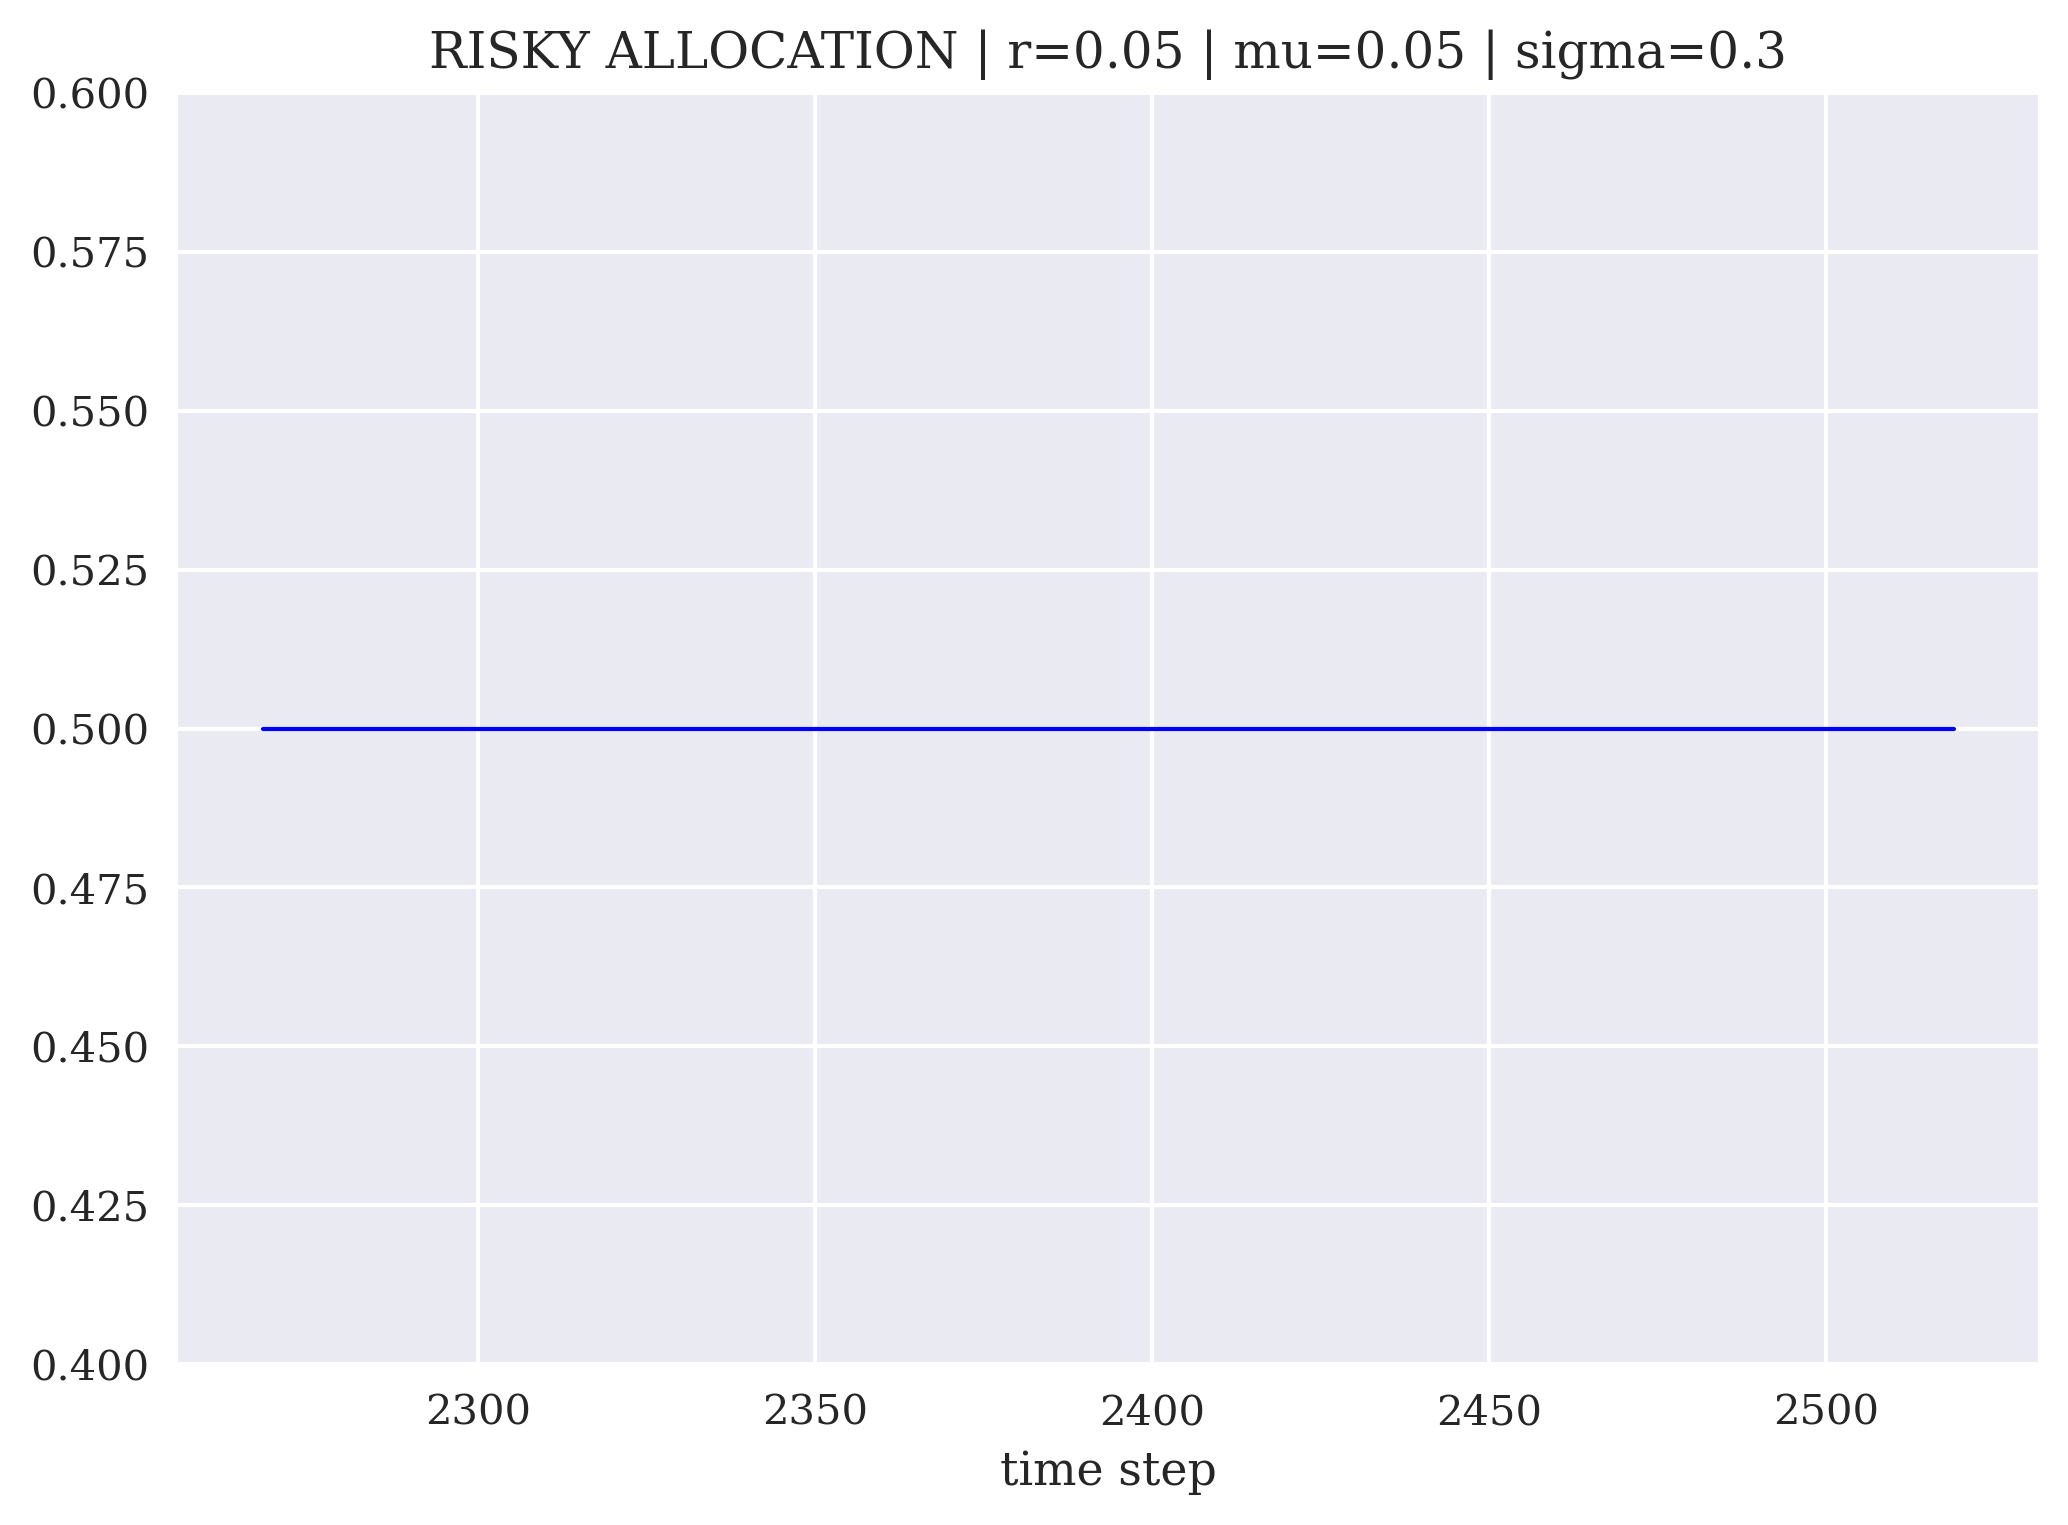

In [48]:
res['xt'].plot(title='RISKY ALLOCATION | ' + t,
               lw=1.0, c='b')
plt.ylim(res['xt'].min() - 0.1, res['xt'].max() + 0.1)
plt.xlabel('time step');

In [49]:
agent.env.portfolios.groupby('mu')['xt'].describe()

,count,mean,std,min,25%,50%,75%,max
mu,,,,,,,,
0.050,756.000,0.500,0.000,0.500,0.500,0.500,0.500,0.500
0.100,1008.000,0.500,0.000,0.500,0.500,0.500,0.500,0.500
0.150,756.000,0.500,0.000,0.500,0.500,0.500,0.500,0.500


In [50]:
agent.env.portfolios.groupby('sigma')['xt'].describe()

,count,mean,std,min,25%,50%,75%,max
sigma,,,,,,,,
0.100,1008.000,0.500,0.000,0.500,0.500,0.500,0.500,0.500
0.200,1008.000,0.500,0.000,0.500,0.500,0.500,0.500,0.500
0.300,504.000,0.500,0.000,0.500,0.500,0.500,0.500,0.500


In [51]:
agent.env.portfolios.groupby('mu')['pv_new'].describe()

,count,mean,std,min,25%,50%,75%,max
mu,,,,,,,,
0.050,756.000,1.057,0.074,0.899,1.004,1.045,1.131,1.207
0.100,1008.000,1.023,0.044,0.891,1.001,1.027,1.050,1.130
0.150,756.000,1.059,0.049,0.978,1.020,1.049,1.093,1.179


In [52]:
agent.env.portfolios.groupby('sigma')['pv_new'].describe()

,count,mean,std,min,25%,50%,75%,max
sigma,,,,,,,,
0.100,1008.000,1.053,0.045,0.978,1.019,1.043,1.079,1.179
0.200,1008.000,1.049,0.069,0.891,1.004,1.035,1.095,1.207
0.300,504.000,1.015,0.049,0.899,0.982,1.015,1.053,1.130


In [53]:
n = max(agent.env.portfolios['e'])

In [54]:
res = agent.env.portfolios[agent.env.portfolios['e'] == n]

In [55]:
p = res.iloc[0][['r', 'mu', 'sigma']]

In [56]:
t = f"r={p['r']} | mu={p['mu']} | sigma={p['sigma']}"

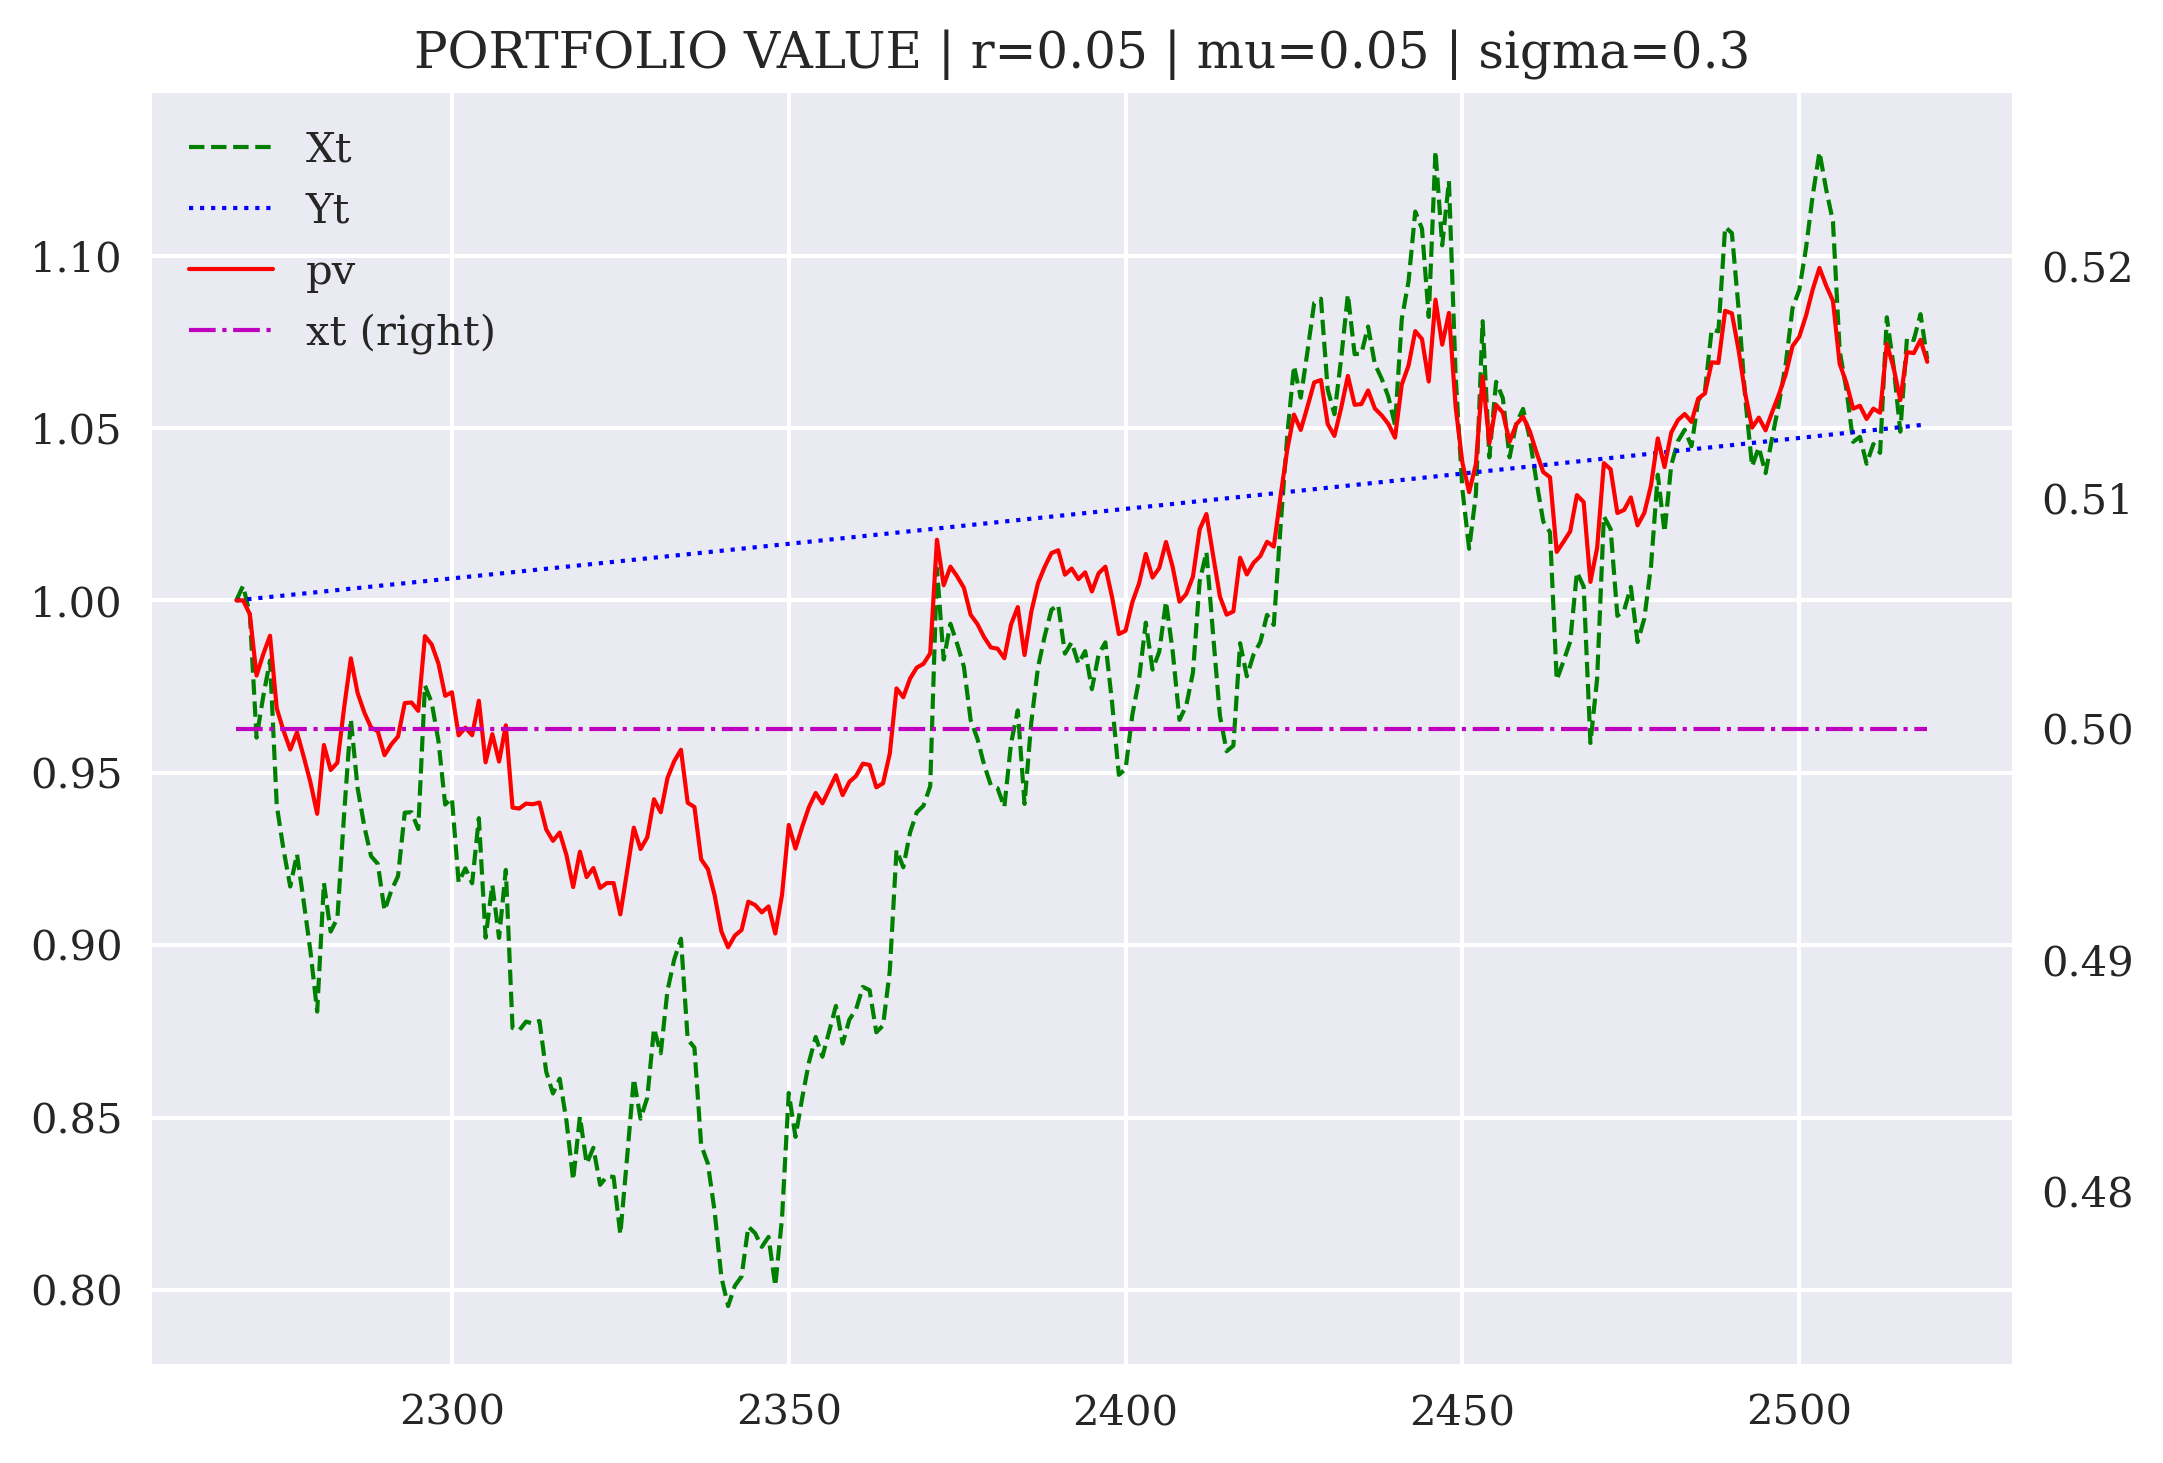

In [57]:
ax = res[['Xt', 'Yt', 'pv', 'xt']].plot(
    title='PORTFOLIO VALUE | ' + t,
    style=['g--', 'b:', 'r-', 'm-.'], lw=1,
    secondary_y='xt'
)

## Two Assets

In [ ]:
class Investing(Investing):
    def __init__(self, asset_one='.SPX', asset_two='.VIX',
                 steps=252, amount=1):
        self.asset_one = asset_one
        self.asset_two = asset_two
        self.steps = steps
        self.initial_balance = amount
        self.portfolio_value = amount
        self.portfolio_value_new = amount
        self.observation_space = observation_space(4)
        self.osn = self.observation_space.shape[0]
        self.action_space = action_space(1)
        self.retrieved = False
        self._generate_data()
        self.portfolios = pd.DataFrame()
        self.episode = 0
        
    def _generate_data(self):
        if self.retrieved:
            pass
        else:
            url = 'https://certificate.tpq.io/rl4finance.csv'
            self.raw = pd.read_csv(url, index_col=0,
                                   parse_dates=True).dropna()
            self.retrieved = True
        self.data = pd.DataFrame()
        self.data['Xt'] = self.raw[self.asset_one]
        self.data['Yt'] = self.raw[self.asset_two]
        s = random.randint(self.steps, len(self.data))
        self.data = self.data.iloc[s-self.steps:s]
        self.data = self.data / self.data.iloc[0]

In [ ]:
class Investing(Investing):        
    def _get_state(self):
        Xt = self.data['Xt'].iloc[self.bar]
        Yt = self.data['Yt'].iloc[self.bar]
        self.date = self.data.index[self.bar]
        return np.array([Xt, Yt, Xt - Yt, self.xt, self.yt]), {}
        
    def add_results(self, pl):
        df = pd.DataFrame({
               'e': self.episode, 'date': self.date,
               'xt': self.xt, 'yt': self.yt,
               'pv': self.portfolio_value,
               'pv_new': self.portfolio_value_new, 'p&l[$]': pl, 
               'p&l[%]': pl / self.portfolio_value_new * 100,
               'Xt': self.state[0],  'Yt': self.state[1],
               'Xt_new': self.new_state[0],
               'Yt_new': self.new_state[1],
                      }, index=[0])
        self.portfolios = pd.concat((self.portfolios, df),
                                    ignore_index=True)

In [ ]:
class Investing(Investing):
    def step(self, action):
        self.bar += 1
        self.new_state, info = self._get_state()
        if self.bar == 1:
            self.xt = action
            self.yt = (1 - action)
            pl = 0.
            reward = 0.
            self.add_results(pl)
        else:
            self.portfolio_value_new = (
                self.xt * self.portfolio_value *
                self.new_state[0] / self.state[0] +
                self.yt * self.portfolio_value *
                self.new_state[1] / self.state[1])
            pl = self.portfolio_value_new - self.portfolio_value
            pen = (self.xt - action) ** 2
            self.xt = action
            self.yt = (1 - action)
            self.add_results(pl)
            ret = self.portfolios['p&l[%]'].iloc[-1] / 100 * 252
            vol = self.portfolios['p&l[%]'].rolling(
                20, min_periods=1).std().iloc[-1] * math.sqrt(252)
            sharpe = ret / vol
            reward = sharpe - pen
            self.portfolio_value = self.portfolio_value_new
        if self.bar == len(self.data) - 1:
            done = True
        else:
            done = False
        self.state = self.new_state
        return self.state, reward, done, False, {}

In [ ]:
days = 2 * 252

In [ ]:
investing = Investing(steps=days)

In [ ]:
investing.data.head()

In [ ]:
investing.data.corr()

In [ ]:
investing.data.plot(secondary_y='Yt',
                    style=['b', 'g--'], lw=1);

In [ ]:
set_seeds()

In [ ]:
investing = Investing(steps=days)

In [ ]:
agent = InvestingAgent('2AC', feature=None, n_features=5,
                     env=investing, hu=48, lr=0.0005)

In [ ]:
agent.xp = 3
agent.yp = 4

In [ ]:
episodes = 10

In [ ]:
%time agent.learn(episodes)

In [ ]:
agent.epsilon

In [ ]:
agent.env.portfolios = pd.DataFrame()

In [ ]:
%time agent.test(10)

In [ ]:
agent.env.portfolios['xt'].describe()

In [ ]:
n = max(agent.env.portfolios['e']) - 3

In [ ]:
res = agent.env.portfolios[
        agent.env.portfolios['e'] == n].set_index('date')

In [ ]:
res['xt'].plot(lw=1, c='b')
plt.ylim(res['xt'].min() - 0.1, res['xt'].max() + 0.1)
plt.ylabel('allocation (asset 1)');


In [ ]:
res[['Xt', 'Yt', 'pv']].iloc[-1]

In [ ]:
r = np.log(res[['Xt', 'Yt', 'pv']] /
           res[['Xt', 'Yt', 'pv']].shift(1))

In [ ]:
rets = np.exp(r.mean() * 252) - 1
rets

In [ ]:
stds = r.std() * math.sqrt(252)
stds

In [ ]:
rets / stds

In [ ]:
res[['Xt', 'Yt', 'pv']].plot(
    title='PORTFOLIO VALUE',
    style=['g--', 'b:', 'r-'],
    lw=1, grid=True)
plt.ylabel('value');


In [ ]:
values = agent.env.portfolios.groupby('e')[
        ['Xt', 'Yt', 'pv_new']].last()
values.tail()

In [ ]:
values.mean()

In [ ]:
((values['pv_new'] > values['Xt']) &
 (values['pv_new'] > values['Yt'])).value_counts()

In [ ]:
agent.env.portfolios.groupby(['e'])['pv_new'].last()

<img src="http://hilpisch.com/tpq_logo.png" alt="The Python Quants" width="35%" align="right" border="0"><br>

<a href="http://tpq.io" target="_blank">http://tpq.io</a> | <a href="http://twitter.com/dyjh" target="_blank">@dyjh</a> | <a href="mailto:team@tpq.io">team@tpq.io</a>